In [1]:
import math,csv, random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.special import erf
import matplotlib.mlab as mlab
import scipy.integrate as integrate
import matplotlib.patches as mpatches
import pylab as P
from scipy.optimize import minimize
from statsmodels.sandbox.stats.multicomp import multipletests
from collections import Counter
from scipy import signal
import imp
from numpy import linalg as LA
from statsmodels.sandbox.stats.multicomp import *
from scipy.stats import norm

        
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [4]:
def Bh_q(pvals, q):
    n = pvals.shape[0]
    sort_order = np.argsort(pvals)
    reverse_sort_order = np.argsort(sort_order)
    p_vals_sorted = pvals[sort_order]
    p_vals_sorted_adjusted = n*p_vals_sorted/(np.arange(1,n+1)*q)
    Rejected = np.array([False]*n)
    Rejected[np.where(p_vals_sorted_adjusted<1)] = True
    
    return Rejected[reverse_sort_order], p_vals_sorted_adjusted[reverse_sort_order]


In [74]:
def gaussian_alternate_estimate_bhq_lasso(mu_1=3, sigma_1=1):
    q_num = 50
    no_exp = 30
    mu_0 = 0
    lasso_ht_mean = 0
    lasso_st_mean = 0
    sigma_1 = 1
    sigma_2 = sigma_1
    null_size = 1000 - 50
    alternate_size = 50
    n = null_size + alternate_size
    estimated_bhq_mean = np.zeros([q_num-1,2])
    for i, q in enumerate(np.arange(0.01,.5,.5/(q_num-1))):
        bhq_mean = 0
        for j in range(no_exp):
            null_obs = np.random.normal(mu_0,sigma_1, size = null_size)
            alternate_obs = np.random.normal(mu_1,sigma_2, size = alternate_size)
            all_obs = np.append(null_obs, alternate_obs)
            ST = all_obs-np.sqrt(2*np.log(null_size))
            ST = ST[np.where(ST>0)]
            lasso_st_mean += np.mean(ST)
            null_pvals = 1 - norm.cdf(null_obs, mu_0, sigma_1)
            alternate_pvals = 1 - norm.cdf(alternate_obs, mu_0, sigma_1)
            all_pvals = np.append(null_pvals, alternate_pvals)

            hypothesis_test_result = Bh_q(all_pvals, q)[0]
            rejected = np.where(hypothesis_test_result==True)
            bhq_mean += np.mean(all_obs[rejected]) 

        estimated_bhq_mean[i] =[q , bhq_mean/no_exp]
    estimated_lasso_mean = lasso_st_mean/(q_num*no_exp)
    plt.figure(figsize=(14,4))
    plt.plot( estimated_bhq_mean[:,0], estimated_bhq_mean[:,1], label = "Mean of rejected hypothesis")
    plt.axhline(mu_1, linestyle= '--', color = 'black', label = "True mean = "+str(mu_1))
    plt.axhline(estimated_lasso_mean, linestyle= '--', color = 'green', label = "ST Lasso Mean = "+str(estimated_lasso_mean))
    plt.axhline(estimated_lasso_mean+np.sqrt(2*np.log(null_size)), color = 'green', \
                label = "HT Lasso Mean = "+str(estimated_lasso_mean+np.sqrt(2*np.log(null_size))))
    plt.axvline((alternate_size+0.0)/(n+0.0), linestyle= '-', color = 'black', \
                label = "1-pi_0 = "+str((alternate_size+0.0)/(n+0.0)) )
    plt.legend()
    plt.show()



In [213]:
def FDR_gibbs(mu_1=3, sigma_1=1, beta=1):
    no_exp = 10
    mu_0 = 0
    lasso_ht_mean = 0
    lasso_st_mean = 0
    sigma_1 = 1
    sigma_2 = sigma_1
    n = 500
    pi_o = 0.1
    S_num = int(n*pi_o)
    alternate_size = int(n*pi_o)
    null_size = n - alternate_size
    estimated_bhq_mean = np.zeros(S_num)
    estimated_fdr_mean = np.zeros(S_num)
    estimated_fd_mean = np.zeros(S_num)
    estimated_d_mean = np.zeros(S_num)
    for S in np.arange(1,S_num):
        fdr_mean = 0
        fd_mean  = 0
        d_mean  = 0
        bhq_mean = 0
        for j in range(no_exp):
            null_obs = np.random.normal(mu_0,sigma_1, size = null_size)
            alternate_obs = np.random.normal(mu_1,sigma_2, size = alternate_size)
            all_obs = np.append(null_obs, alternate_obs)
            null_pvals = 1 - norm.cdf(null_obs, mu_0, sigma_1)
            alternate_pvals = 1 - norm.cdf(alternate_obs, mu_0, sigma_1)
            all_pvals = np.append(null_pvals, alternate_pvals)
            
            p_rejection_gibbs = np.exp(-beta*all_pvals)
            p_rejection_gibbs = S*p_rejection_gibbs/np.sum(p_rejection_gibbs)
            uniform_random_var = np.random.uniform(size=n)
            reject = uniform_random_var < p_rejection_gibbs
            Total_Discoveries = len(np.where(reject==True)[0])+0.0
            False_Discoveries = len(np.where(reject[:null_size]==True)[0])+0.0
#             print all_pvals
#             print reject
#             print list(p_rejection_gibbs)
#             print uniform_random_var, "\n", Total_Discoveries, False_Discoveries
            d_mean   += Total_Discoveries
            fd_mean  += False_Discoveries
            fdr_mean += False_Discoveries/(max(1,Total_Discoveries))
            
            
#             hypothesis_test_result = Bh_q(all_pvals, q)[0]
#             Total_Discoveries = len(np.where(hypothesis_test_result==True)[0])+0.0
#             False_Discoveries = len(np.where(hypothesis_test_result[:null_size]==True)[0])+0.0
#             bhq_mean += False_Discoveries/(max(1,Total_Discoveries))
 
#         estimated_bhq_mean[S] = bhq_mean/no_exp
        estimated_fdr_mean[S] = fdr_mean/no_exp
        estimated_fd_mean[S] = fd_mean/no_exp
        estimated_d_mean[S] = d_mean/no_exp
#     plt.figure(figsize=(14,4))
#     plt.ylim(0,1.2)
#     plt.xlabel("|S|")
#     plt.ylabel("FDR")
#     plt.title("beta ="+str(beta))
#     plt.plot(estimated_fdr_mean, label="gibbs")
# #     plt.plot(estimated_bhq_meanm, label="fdr")
#     plt.legend()
#     plt.figure(figsize=(14,4))
#     plt.xlabel("|S|")
#     plt.ylabel("FD")
#     plt.title("beta ="+str(beta))
#     plt.plot(estimated_fd_mean, label="false discoveries")
#     plt.plot(estimated_d_mean, label="discoveries")
#     plt.plot(range(S_num), label="S_num")
#     plt.legend()
#     plt.show()
    return estimated_fdr_mean, estimated_d_mean



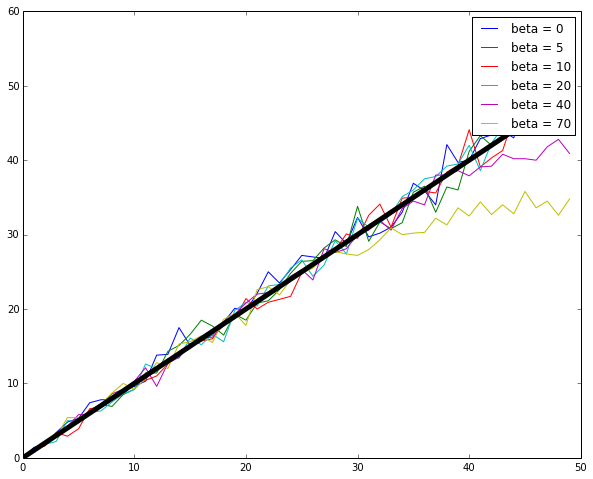

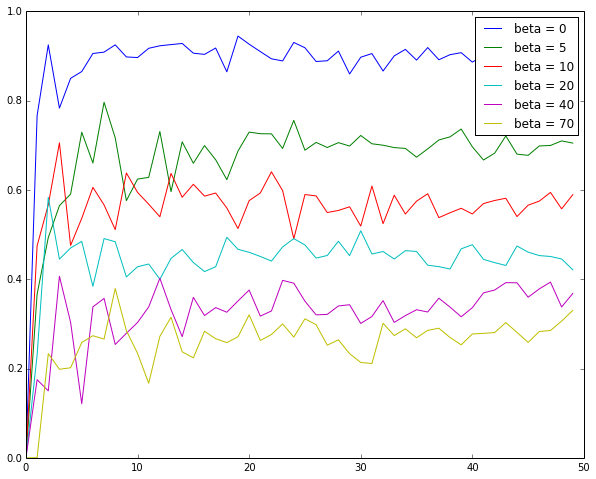

In [214]:
beta_array = [0,5,10,20,40,70]
for beta in beta_array:
    estimated_fdr_mean, estimated_d_mean = FDR_gibbs(mu_1=2, sigma_1=1, beta=beta)
    plt.plot( estimated_d_mean , label="beta = "+ str(beta))
plt.plot(range(50), linewidth = 5)
plt.legend()

plt.figure()
for beta in beta_array:
    estimated_fdr_mean, estimated_d_mean = FDR_gibbs(mu_1=2, sigma_1=1, beta=beta)
    plt.plot( estimated_fdr_mean , label="beta = "+ str(beta))
plt.legend()
plt.show()

In [215]:
FDR_gibbs(mu_1=10, sigma_1=1, beta=10)

(array([ 0.        ,  0.4       ,  0.37666667,  0.51166667,  0.47111111,
         0.53333333,  0.41444444,  0.40252831,  0.49404762,  0.44361111,
         0.51026696,  0.52848485,  0.51569489,  0.45412547,  0.45518337,
         0.41788776,  0.44324694,  0.47172142,  0.56585258,  0.51119854,
         0.46524055,  0.5101246 ,  0.52609241,  0.44828395,  0.42555403,
         0.44325522,  0.45147115,  0.50512284,  0.48929912,  0.44939686,
         0.46894093,  0.44447426,  0.4479859 ,  0.48273998,  0.48252429,
         0.44355652,  0.46433562,  0.48738191,  0.47944587,  0.4987672 ,
         0.46504418,  0.44083278,  0.4714294 ,  0.44289575,  0.49342847,
         0.47070161,  0.48631048,  0.46186206,  0.44861617,  0.4553511 ]),
 array([  0. ,   0.7,   2.9,   3.9,   3.6,   4.6,   5.9,   8.1,   8. ,
          8.2,  10.6,  10.2,  12.2,  12.4,  12.6,  14.8,  15.2,  17.3,
         17.4,  20. ,  18.4,  21.7,  20.3,  21.6,  24.6,  25.5,  27.5,
         28.3,  30.8,  26.2,  30.4,  30.2,  33.6,  31.5

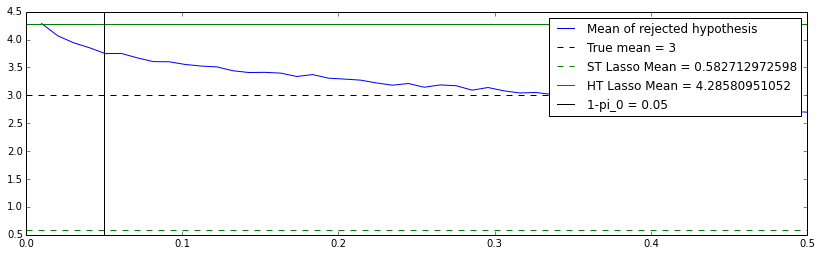

In [76]:
gaussian_alternate_estimate_bhq_lasso(mu_1=3, sigma_1=1)

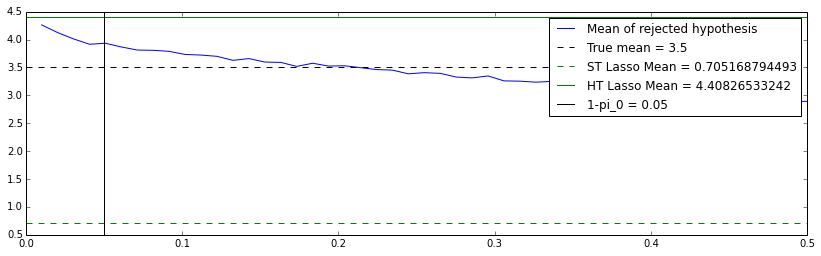

In [77]:
gaussian_alternate_estimate_bhq_lasso(mu_1=3.5, sigma_1=1)

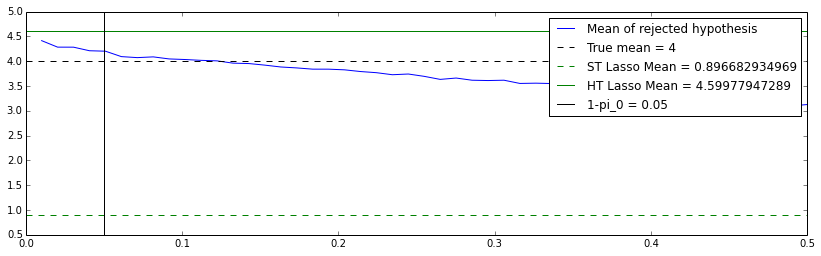

In [78]:
gaussian_alternate_estimate_bhq_lasso(mu_1=4, sigma_1=1)

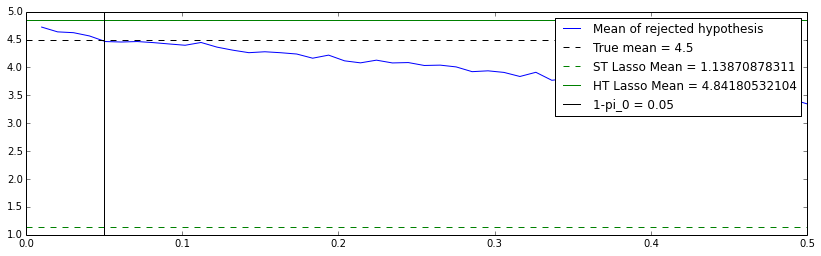

In [79]:
gaussian_alternate_estimate_bhq_lasso(mu_1=4.5, sigma_1=1)

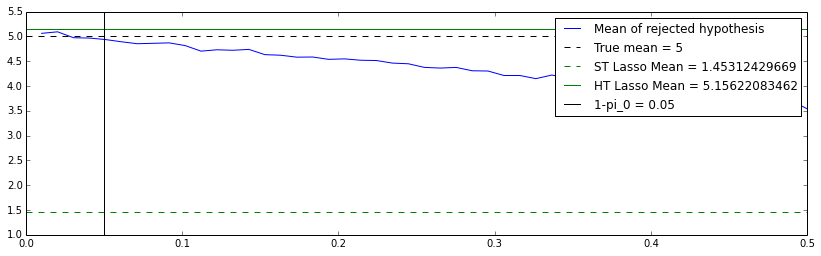

In [80]:
gaussian_alternate_estimate_bhq_lasso(mu_1=5, sigma_1=1)